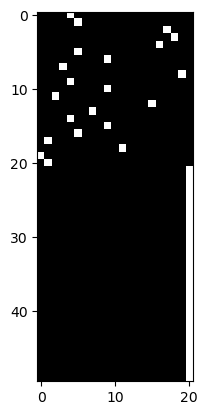

In [279]:
# Import Statements:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import requests
import pandas
import matplotlib.pyplot as plt
import numpy as np

# Creating Constants:

AMINO_ACIDS = {
 'N': 0,
 'L': 1,
 'V': 2, 
 'S': 3,
 'G': 4,
 'I': 5, 
 'E': 6, 
 'A': 7,
 'R': 8, 
 'K': 9,
 'Y': 10,
 'Q': 11,
 'H': 12, 
 'C': 13,
 'P': 14,
 'F': 15,
 'T': 16, 
 'W': 17, 
 'D': 18,
 'M': 19,
 '_': 20
}

AMINO_ACIDS_REV = {
 0: 'N',
 1: 'L',
 2: 'V',
 3: 'S',
 4: 'G',
 5: 'I',
 6: 'E',
 7: 'A',
 8: 'R',
 9: 'K',
 10: 'Y',
 11: 'Q',
 12: 'H',
 13: 'C',
 14: 'P',
 15: 'F',
 16: 'T',
 17: 'W',
 18: 'D',
 19: 'M',
 20: '_'
}

MAX_LENGTH = 50
INPUT_DIM = 1050
H_DIM = 100
Z_DIM = 10
EPOCHS = 5000
LR = 3e-5

# Creating Training Data:

PATH = 'Antimicrobial_Peptide_Data.csv'

data_frame = pd.read_csv(FILE_PATH)

train_data = data_frame["SEQUENCE"].values

# Cleaning Training Data

temp_data = []

for data in train_data:
    clean = True

    for ix in range(len(data)):

        if data[ix] not in AMINO_ACIDS:
            clean = False

    if clean:
        temp_data.append(data)

# Converting Training Data to Tensor Using One-Hot Encoding:

train_data = torch.zeros((len(train_data), 50, 21))

for i, data in enumerate(temp_data):
    sequence = torch.zeros((50, 21))

    for ix in range(MAX_LENGTH):
        
        if ix < len(data):
            sequence[ix] = F.one_hot(torch.tensor(AMINO_ACIDS.get(data[ix])), 21)
        else:
            sequence[ix] = F.one_hot(torch.tensor(20), 21)

    train_data[i] = sequence

# Visualizing Sample Peptide (Ubiquitin):

sample = train_data[3]

plt.imshow(sample, cmap='grey')


In [280]:
# Creating Variational AutoEncoder:

class VariationalAutoEncoder(nn.Module):

    def __init__(self, input_dim, h_dim, z_dim):
        super().__init__()

        self.input_dim = input_dim
        self.h_dim = h_dim
        self.z_dim = z_dim

        # Creating Encoder:

        self.i_2h = nn.Linear(input_dim, h_dim)
        self.h_2mu = nn.Linear(h_dim, z_dim)
        self.h_2sigma = nn.Linear(h_dim, z_dim)

        # Creating Decoder:

        self.z_2h = nn.Linear(z_dim, h_dim)
        self.h_2i = nn.Linear(h_dim, input_dim)

    def encode(self, x):
        x = x.view(-1, self.input_dim)
        
        h = F.relu(self.i_2h(x))
        mu, sigma = self.h_2mu(h), self.h_2sigma(h)
        return mu, sigma

    def decode(self, z):
        z = z.view(-1, self.z_dim)
        
        h = F.relu(self.z_2h(z))
        return torch.sigmoid(self.h_2i(h))

    def forward(self, x):
        mu, sigma = self.encode(x)
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        z = mu + sigma * eps
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, sigma

model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM)

# Verifying Output Dimensions:

sample = train_data[0]

x, mu, sigma = model(sample)

x.shape, mu.shape, sigma.shape


(torch.Size([1, 1050]), torch.Size([1, 10]), torch.Size([1, 10]))

In [281]:
# Batching Training Data:

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Creating Criterion:

criterion = nn.BCELoss(reduction="sum")

# Creating Optimizer:

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Creating Training Loop:

for epoch in range(EPOCHS):

    for batch, x in enumerate(train_loader):

        batch += 1

        x = x.view(-1, INPUT_DIM)

        x_reconstructed, mu, sigma = model(x)

        reconstruction_loss = criterion(x_reconstructed, x)

        KV_div_loss = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        loss = reconstruction_loss = KV_div_loss

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} Loss: {loss:.4f}')



Epoch: 0 Loss: 980.2922
Epoch: 100 Loss: 0.0007
Epoch: 200 Loss: 0.0002
Epoch: 300 Loss: 0.0011
Epoch: 400 Loss: 0.0006
Epoch: 500 Loss: 0.0011
Epoch: 600 Loss: 0.0002
Epoch: 700 Loss: 0.0003
Epoch: 800 Loss: 0.0002
Epoch: 900 Loss: 0.0005
Epoch: 1000 Loss: 0.0002
Epoch: 1100 Loss: 0.0006
Epoch: 1200 Loss: 0.0001
Epoch: 1300 Loss: 0.0002
Epoch: 1400 Loss: 0.0002
Epoch: 1500 Loss: 0.0002
Epoch: 1600 Loss: 0.0002
Epoch: 1700 Loss: 0.0001
Epoch: 1800 Loss: 0.0001
Epoch: 1900 Loss: 0.0001
Epoch: 2000 Loss: 0.0001
Epoch: 2100 Loss: 0.0001
Epoch: 2200 Loss: 0.0001
Epoch: 2300 Loss: 0.0001
Epoch: 2400 Loss: 0.0006
Epoch: 2500 Loss: 0.0001
Epoch: 2600 Loss: 0.0001
Epoch: 2700 Loss: 0.0001
Epoch: 2800 Loss: 0.0001
Epoch: 2900 Loss: 0.0001
Epoch: 3000 Loss: 0.0001
Epoch: 3100 Loss: 0.0001
Epoch: 3200 Loss: 0.0001
Epoch: 3300 Loss: 0.0000
Epoch: 3400 Loss: 0.0001
Epoch: 3500 Loss: 0.0000
Epoch: 3600 Loss: 0.0003
Epoch: 3700 Loss: 0.0001
Epoch: 3800 Loss: 0.0001
Epoch: 3900 Loss: 0.0001
Epoch: 400

In [292]:
# Evaluating Accuracy of Model:

NEW_SEQUENCES = 10

for ix in range(NEW_SEQUENCES):

    noise = torch.randn((50, 21))

    x, mu, sigma = model(noise)

    x = x.view(50, 21)

    new_sequence = ""

    for i in range(50):

        acid = AMINO_ACIDS_REV.get(torch.argmax(x[i]).item())

        if acid == '_':
            break
        else:
            new_sequence += acid

    print(new_sequence)


QT
DNKHDCVCWWCYRYQMMYVGCQRTMHIKLRQHLPTKALYINAKGFYEVNI
TWEFYMMFNEEAVDHVFWSEKVQMCSPMAMSM
TL
DNLENNKGSNQPCQAL
DNDIYGMSWVDERQTLWCAHSAGCAVIWLNRCKPFKMYYNNADLN
DTIQHCVHNKHHTYLLCEMEFFRLAYWWWINGAIGMCHENWNKQIPD
TQLIQCDSSAAPTKTHWEAGNHDCHEAWLRKT
DS
GQKFYMNGWKKQLG
